In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE


In [5]:
# Load the train and test data
train_df = pd.read_csv("/fraudTrain.csv")
test_df = pd.read_csv("/fraudTest.csv")

# Drop the unnamed index column (if exists)
train_df.drop(columns=['Unnamed: 0'], inplace=True)
test_df.drop(columns=['Unnamed: 0'], inplace=True)

# Combine the datasets for preprocessing
df = pd.concat([train_df, test_df], ignore_index=True)

print("Shape:", df.shape)
df.head()


Shape: (1852394, 22)


trans_date_trans_time            cc_num                            merchant  \
0   2019-01-01 00:00:18  2703186189652095          fraud_Rippin, Kub and Mann   
1   2019-01-01 00:00:44      630423337322     fraud_Heller, Gutmann and Zieme   
2   2019-01-01 00:00:51    38859492057661                fraud_Lind-Buckridge   
3   2019-01-01 00:01:16  3534093764340240  fraud_Kutch, Hermiston and Farrell   
4   2019-01-01 00:03:06   375534208663984                 fraud_Keeling-Crist   

        category     amt      first     last gender  \
0       misc_net    4.97   Jennifer    Banks      F   
1    grocery_pos  107.23  Stephanie     Gill      F   
2  entertainment  220.11     Edward  Sanchez      M   
3  gas_transport   45.00     Jeremy    White      M   
4       misc_pos   41.96      Tyler   Garcia      M   

                         street            city  ...      lat      long  \
0                561 Perry Cove  Moravian Falls  ...  36.0788  -81.1781   
1  43039 Riley Greens Suite 393          Orient  ...  48.8878 -118.2105   
2      594 White Dale Suite 530      Malad City  ...  42.1808 -112.2620   
3   9443 Cynthia Court Apt. 038         Boulder  ...  46.2306 -112.1138   
4              408 Bradley Rest        Doe Hill  ...  38.4207  -79.4629   

   city_pop                                job         dob  \
0      3495          Psychologist, counselling  1988-03-09   
1       149  Special educational needs teacher  1978-06-21   
2      4154        Nature conservation officer  1962-01-19   
3      1939                    Patent attorney  1967-01-12   
4        99     Dance movement psychotherapist  1986-03-28   

                          trans_num   unix_time  merch_lat  merch_long  \
0  0b242abb623afc578575680df30655b9  1325376018  36.011293  -82.048315   
1  1f76529f8574734946361c461b024d99  1325376044  49.159047 -118.186462   
2  a1a22d70485983eac12b5b88dad1cf95  1325376051  43.150704 -112.154481   
3  6b849c168bdad6f867558c3793159a81  1325376076  47.034331 -112.561071   
4  a41d7549acf90789359a9aa5346dcb46  1325376186  38.674999  -78.632459   

   is_fraud  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 22 columns]

In [6]:
print(df.info())
print(df['is_fraud'].value_counts())  # 0 = not fraud, 1 = fraud


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   gender                 object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int64  
dtypes: float64(5), int

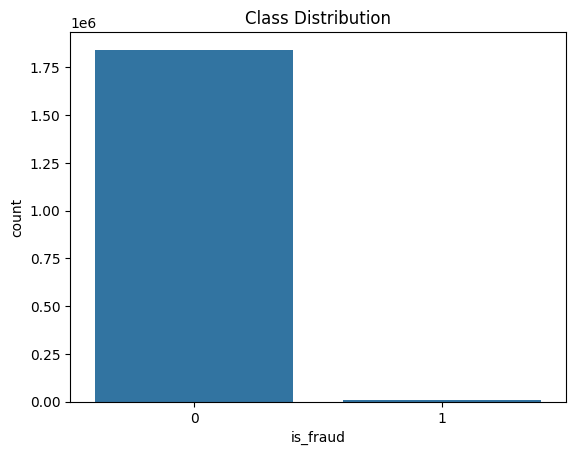

In [8]:
# Plot imbalance
sns.countplot(x='is_fraud', data=df)
plt.title("Class Distribution")
plt.show()


In [9]:
df.drop(['trans_num', 'unix_time', 'first', 'last', 'street', 'dob'], axis=1, inplace=True)


In [10]:
#Convert trans_date_trans_time to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month
df.drop('trans_date_trans_time', axis=1, inplace=True)


In [11]:
#Encode Categorical Variables
cat_cols = ['merchant', 'category', 'gender', 'city', 'state', 'job']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])


In [12]:
print(df.info())
print(df.isnull().sum())  # Check for missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 18 columns):
 #   Column      Dtype  
---  ------      -----  
 0   cc_num      int64  
 1   merchant    int64  
 2   category    int64  
 3   amt         float64
 4   gender      int64  
 5   city        int64  
 6   state       int64  
 7   zip         int64  
 8   lat         float64
 9   long        float64
 10  city_pop    int64  
 11  job         int64  
 12  merch_lat   float64
 13  merch_long  float64
 14  is_fraud    int64  
 15  hour        int32  
 16  day         int32  
 17  month       int32  
dtypes: float64(5), int32(3), int64(10)
memory usage: 233.2 MB
None
cc_num        0
merchant      0
category      0
amt           0
gender        0
city          0
state         0
zip           0
lat           0
long          0
city_pop      0
job           0
merch_lat     0
merch_long    0
is_fraud      0
hour          0
day           0
month         0
dtype: int64


In [14]:
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']


In [15]:
#Apply SMOTE for Class Balance
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

print(pd.Series(y_resampled).value_counts())


is_fraud
0    1842743
1    1842743
Name: count, dtype: int64


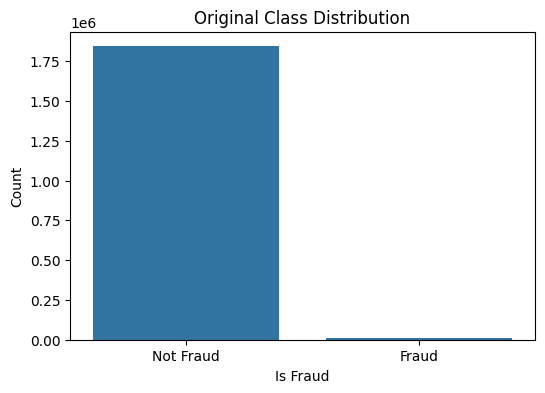

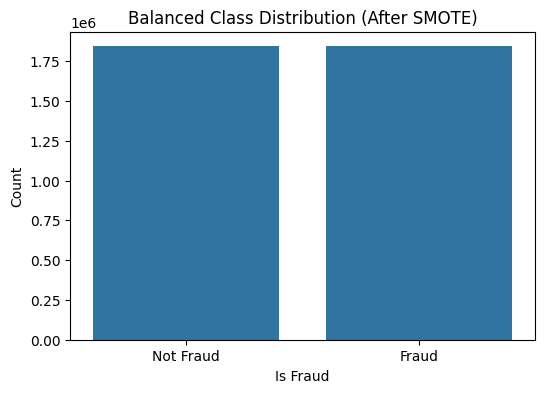

In [24]:
# Original class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud', data=df)
plt.title('Original Class Distribution')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.show()

# After SMOTE
plt.figure(figsize=(6,4))
sns.countplot(x=y_resampled)
plt.title('Balanced Class Distribution (After SMOTE)')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.show()


In [20]:
from sklearn.model_selection import train_test_split

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


In [21]:
from sklearn.ensemble import RandomForestClassifier

# Use all CPU cores with a smaller number of trees for speed
model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [22]:
# Predict on the test set
y_pred = model.predict(X_test)


In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9975457808866663

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    368549
           1       1.00      1.00      1.00    368549

    accuracy                           1.00    737098
   macro avg       1.00      1.00      1.00    737098
weighted avg       1.00      1.00      1.00    737098


Confusion Matrix:
 [[367063   1486]
 [   323 368226]]


<ipython-input-25-12c14f4e59ec>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices][:15], y=features[indices][:15], palette="viridis")


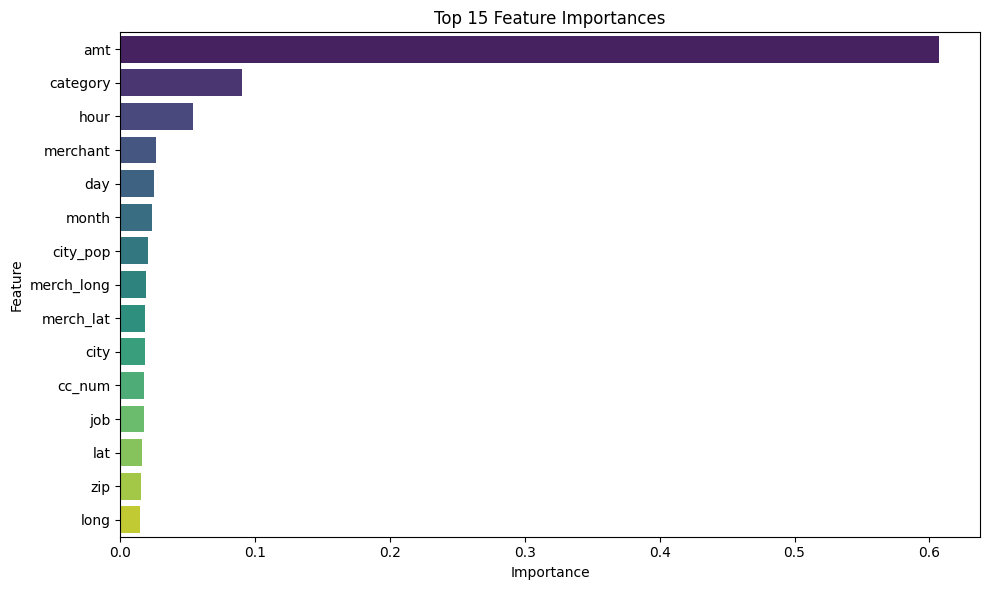

In [25]:
# Feature Importance Plot
importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices][:15], y=features[indices][:15], palette="viridis")
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


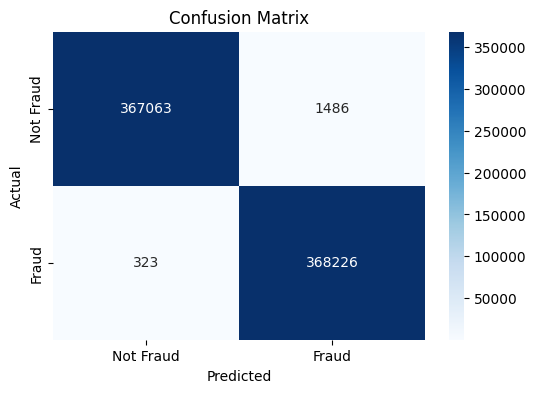

In [26]:
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


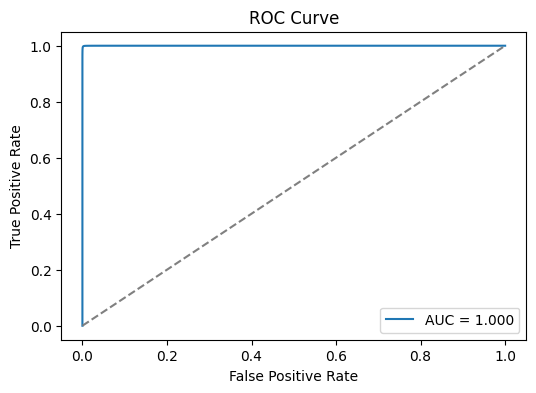

In [27]:
# ROC Curve
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="AUC = {:.3f}".format(auc_score))
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
